In [31]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd

from scipy.optimize import fsolve
from sklearn.model_selection import ParameterGrid
import seaborn as sns

from tqdm import tqdm


# Definitions

In [32]:
OUTPUT_IMG_PATH = 'Images'

In [33]:
# $POKT price in u$d
price_pokt_usd = 0.04118
# Current POKT supply
pokt_supply = 1500379197357628*1e-6

# DAO spending per day in POKT
dao_spending = 3638.726708333333

# DAO earning proportion
DAO_earning_prop = 0.10
# Validator earning proportion
VAL_proportion = 0.05

# investments (tokens staked)
investment_day = 690414.7672799333

# Tokens burn due to proofs/sends per day
transaction_burn_claim_proof_by_day = 2891.719152791667
# Token minting per day (before any tax, validator or dao)
pokt_production_per_day = 523262.97609300003

# Cost of the network per year in u$d
network_cost_year = 15e6
network_cost_day = network_cost_year/(365.)

# Relays per day
relays_by_day = 1.2e9 

# Average RTTM (just for cosmetic ops, almost...)
rttm_avg = pokt_production_per_day/relays_by_day





In [34]:
# Current income of the network if we use PNI
paid_relays = 200e6 # From released document
PNI_buy_and_hold_proportion = 0.6 # Reference needed...
PNI_relay_price = 0.000007456 # From portal page in u$d
PNI_relay_price_POKT = PNI_relay_price*price_pokt_usd
# Proportion of paid relays to total relays
current_paid_proportion=(paid_relays/relays_by_day)

app_burn_rate_eq_PNI = current_paid_proportion*rttm_avg*pokt_production_per_day


USE_PNI_INCOME = False

In [35]:
app_burn_rate_ini = 0#0.00000085 / price_pokt_usd

### Expexted Node Return

In [36]:
pokt_node_stake = 15e3
mean_income_15k_block = 0.11493336919961748 # POKT per node 
mean_income_15k_4months = mean_income_15k_block*30*4*24*4

In [37]:
# POKT interest rate equal to node expected return (not true in real life!)
pokt_rate = (mean_income_15k_4months/pokt_node_stake)*12/4

### Reference Interest Rate

In [38]:
price_pokt_usd_init = 0.07267
price_eth_usd_end = 1941.
price_eth_usd_init = 1217.
# ETH interest rate
ETH_rate = 0.05
pool_fee_eth = 0.02
# Year APR
eth_apr = ETH_rate*(1-pool_fee_eth)
months = 4
# Eth at begining of period
pokt2usd_ini = pokt_node_stake * price_pokt_usd_init
usd2eth_ini = pokt2usd_ini / price_eth_usd_init
# Eth at the end of period: Eth ini + rewards
eth_end = usd2eth_ini * (1 + eth_apr/(12) * months)
# POKT at end of period
eth2usd_end = eth_end * price_eth_usd_end
pokt_end = eth2usd_end / price_pokt_usd
# ETH insterest rate meassured in POKT
ETH_POKT_rate = ((pokt_end - pokt_node_stake) / pokt_node_stake)*12/4


# Define and Fit Model Functions

### Consuption

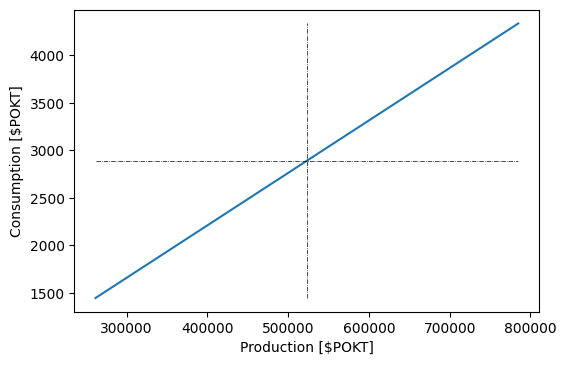

In [39]:
def C_consumption(Y_production : float, 
                  T_taxing : float,
                  c_0 = 0.,
                  c_1 = 0.0008,
                  c_2 = lambda x, y: 0.,
                  ) -> float:
    '''
    Calculates the consumption as a function of the production and the DAO
    taxing.

    Parameters:
        Y_production : Network production in $POKT.
        T_dao_earning : Total DAO earning in $POKT.
        c_0 : Base consumption, not related to production.
        c_1 : Proportion of production that is transformed into consuption 
              (cost of producing).
        c_2 : Function that relates the consumption and DAO taxing with the net 
              gains of production.
    Returns:
        C : Consumption in $POKT
    '''

    C = c_0  + c_1*Y_production + c_2(Y_production, T_taxing)

    return C

# The base consumption is considered null as the amount of transactions
# independent from production is negligeble.
c_0 = 0. 
# The amount of transactions that are related to the mount of net production 
# gains (like distribution rewards, send to exchanges, stakes, etc) is also
# negligeble.
c_2 = lambda x, y: 0.
# The amount of consumption related to production (transactions like claim and 
# proofs) is linear with the production. Given current values of minting and 
# total transaction payment, we can get the value of c_1
c_1 = transaction_burn_claim_proof_by_day/pokt_production_per_day

# Lets plot this curve
y = np.linspace(pokt_production_per_day*0.5,pokt_production_per_day*1.5,100)
d = y*(DAO_earning_prop+VAL_proportion) # DAO and validators take this much
c = np.array([C_consumption(a, b, c_0=c_0, c_1=c_1, c_2=c_2) for a,b in zip(y,d)])
plt.figure(dpi = 100)
plt.plot(y, c)
plt.ylabel('Consumption [$POKT]')
plt.xlabel('Production [$POKT]')
plt.vlines(x=pokt_production_per_day, ymin = c.min(), ymax = c.max(), linestyles='-.', color='black', linewidth=0.5)
plt.hlines(y=transaction_burn_claim_proof_by_day, xmin = y.min(), xmax = y.max(), linestyles='-.', color='black', linewidth=0.5)
plt.savefig(OUTPUT_IMG_PATH + '/C.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [40]:
c_1

0.005526320960796811

### Balance of Trade - Current Account

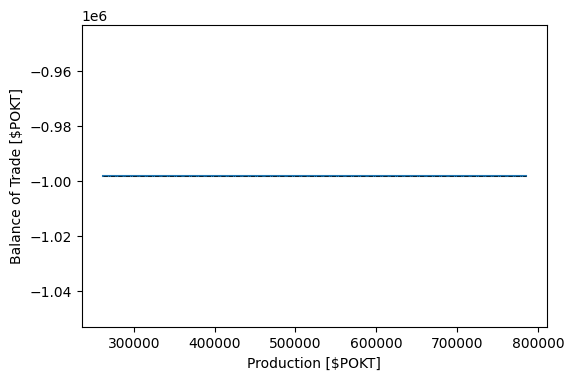

In [41]:

def NX_current_account(e_exchange_rate : float, 
                        Y_production : float,
                        network_cost = lambda x : 100.,
                        network_profit = None,
                        rttm = 100.,
                        app_burn_rate = 0.01,
                        ) -> float:
    '''
    Calculates the balance of trade status as a function of production and 
    exchange rate.

    Parameters:
        e_exchange_rate : Exchange rate in [$POKT/u$d].
        Y_production : Network production in $POKT.
        network_cost : Function that relates the u$d cost of the network with the production levels.
        network_profit : Function that relates the u$d profit of the network with the production levels.
    Returns:
        NX : Trade balance in $POKT
    '''

    # Total imports in $POKT, cost of running the network at current levels
    # of production
    IM = network_cost(Y_production) * e_exchange_rate
    # Total exports in $POKT, payments done to the network at current levels
    # of production (buying to consume, proxy of burning)
    if network_profit == None:
        X = (Y_production/rttm)*app_burn_rate
    else:
        X = network_profit(Y_production) * e_exchange_rate

    # Simply the balance
    NX = (X-IM)

    return NX

# We need to define two functions, how much we will need to pay for the network
# at current levels of production and how much we will receive for the work 
# (all in u$d).

def network_cost_step(y, base_cost):
    # Production is not elastic, we argue that it will cost the same 
    # regardless the production levels. It is actually an step function, having
    # to upgrade costs once a production threshold has been reached.
    return base_cost
network_cost = lambda x : network_cost_step(x, network_cost_day)

if USE_PNI_INCOME:
    def network_profit_v0_PNI(y, rttm, paid_prod, buy_back_share, sell_price):
        # The profit is linear with production, if we asume that the growth will 
        # come only from paid relays.
        # It dependes on two factors, how much does PNI buy back, how much of the 
        # total production is paid for and the price of these relays
        number_of_relays = (y/rttm)
        number_of_paid_relays = number_of_relays*paid_prod
        total_PNI_income = number_of_paid_relays*sell_price
        return buy_back_share*total_PNI_income
    network_profit = lambda x : network_profit_v0_PNI(x, 
                                                rttm_avg, 
                                                current_paid_proportion, 
                                                PNI_buy_and_hold_proportion, 
                                                PNI_relay_price)
else:
    network_profit = None
    

# Create plot
exchange_rate_plot = 1/price_pokt_usd # Constant, it is only here to translate units
current_balance = NX_current_account(exchange_rate_plot,
                                     pokt_production_per_day, 
                                     network_cost=network_cost,
                                     network_profit=network_profit, 
                                     rttm = rttm_avg,
                                     app_burn_rate = app_burn_rate_ini
                                     )
y = np.linspace(pokt_production_per_day*0.5,pokt_production_per_day*1.5,100)
nx = NX_current_account(exchange_rate_plot, 
                        y, 
                        network_cost=network_cost,
                        network_profit=network_profit, 
                        rttm = rttm_avg,
                        app_burn_rate = app_burn_rate_ini
                        )
plt.figure(dpi = 100)
plt.plot(y, nx)
plt.ylabel('Balance of Trade [$POKT]')
plt.xlabel('Production [$POKT]')
plt.vlines(x=pokt_production_per_day, ymin = nx.min(), ymax = nx.max(), linestyles='-.', color='black', linewidth=0.5)
plt.hlines(y=current_balance, xmin = y.min(), xmax = y.max(), linestyles='-.', color='black', linewidth=0.5)
plt.savefig(OUTPUT_IMG_PATH + '/NX.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [42]:
NX_current_account(exchange_rate_plot, 
                                   pokt_production_per_day, 
                                   network_profit=network_profit, 
                                   network_cost=network_cost,
                                   rttm = rttm_avg,
                                    app_burn_rate = app_burn_rate_ini)

-997957.51362212

### Capital Account

/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


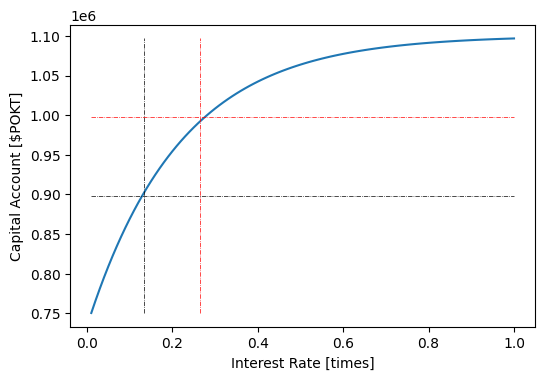

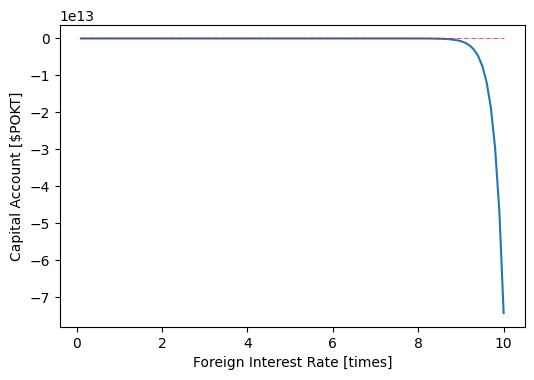

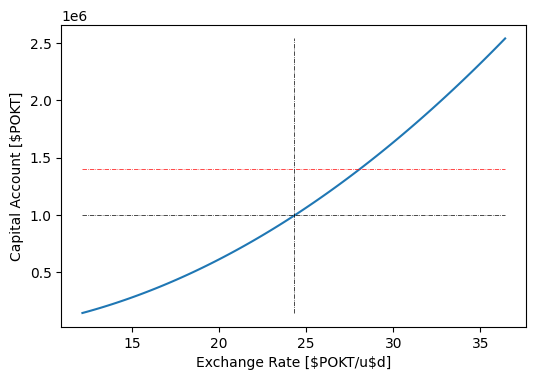

In [43]:
def F_capital_account(r_interest_rate : float,
                      r_interest_rate_external : float,
                      e_exchange_rate : float, 
                      h = 100.,
                      h_0 = 100.,
                      h_k = 100.,
                      b = lambda x : 100.*x,
                      c = lambda x : 100.*x,
                     ) -> float:
    '''
    Calculates the balance of investments as a function of the local interest
    rate and a foreing, more secure, interest rate.

    Parameters:
        r_interest_rate : Interest rate in times inside Pocket ecosystem.
        r_interest_rate_external : Interest rate in times outside Pocket. 
                                    Like ETH interest rate for staking 
                                    (lacking better risk free crypto proxy).
        e_exchange_rate : Exchange rate in [$POKT/u$d].
        h : Function parameter representing the amount of capital entering the 
            system given the diference of interest rates.
        h_0 : Function parameter representing the amount of capital entering the 
            system given the diference of interest rates.
        b : Function that relates the amount of capital leaving the 
            system due to exogenous effects (like USA rising theit interest rate)
        c : Function that relates the amount of capital entering the 
            system due to speculation but forced by imbalances (like node 
            runners putting sale preasure), and regardless the interest rate.
    Returns:
        F : Investment capitals in $POKT
    '''

    # We dont actually know anything about this...
    # Today we are at maximum interest rate and receiving investments for
    # complete speculation. 
    # We think that we survive purely on the force of speculation (parameter "c")

    # F = (h/(r_interest_rate-r_interest_rate_external)) - b(r_interest_rate_external) + c(e_exchange_rate)
    F = (h*(1-1/h_k**((r_interest_rate-r_interest_rate_external))) + h_0) + b(r_interest_rate_external) + c(e_exchange_rate)
    F *= e_exchange_rate

    return F

# The only thing that we know, is that at the currently this should be possitive
# to balance the current account. So:
capital_off_balance = -NX_current_account(exchange_rate_plot, 
                                   pokt_production_per_day, 
                                   network_profit=network_profit, 
                                   network_cost=network_cost,
                                   rttm = rttm_avg,
                                    app_burn_rate = app_burn_rate_ini)*price_pokt_usd
# This is balanced by all things, the h, b anc c, lets imagein how it is composed...
h_prop = -0.2 # Capital is leaving the system at current interest rate and uncertainty
d_prop = -0.2 # Same as above 
c_prop = 1.0-d_prop-h_prop # This guy has to make up for all the leaving capital
# Now lets define the ingress from external interest rate as directly 
# proportional to the current interest of ETH meassured in POKT
b_capital_acc = lambda x : -(d_prop*capital_off_balance/ETH_POKT_rate)*x + 2*(d_prop*capital_off_balance)
# The rest of the imbalance is paid by ingress of capital from that is somehow 
# forced by node runners dumping and driving the price down.
# just use your imagination...
k=1
c_capital_acc_balance = c_prop*capital_off_balance
c_capital_acc = lambda x: (c_capital_acc_balance/(np.power(1/price_pokt_usd,k)))*(np.power(x,k)) 


# Now, to see how much capital will move into the system if we offer a (credible)
# interest rate above the reference we need to use our imagination.
r_interest_rate_guess = np.array([
                                pokt_rate/2.0, 
                                  pokt_rate, 
                                  10])
expected_input_capital = np.array([
                                capital_off_balance*h_prop*1.5, 
                                   capital_off_balance*h_prop, 
                                   capital_off_balance*h_prop*0.5]) # And bloqued in the system for a "long" time
F_guess = expected_input_capital/price_pokt_usd 
# Lets fit
param_bounds=([0.0, -np.inf, 0.01],[1.0, 0.0, 100.])
fit_fn = lambda x,y,z,k : F_capital_account(x, 
                                        ETH_POKT_rate, 
                                        (1/price_pokt_usd),
                                        h=y,
                                        h_0=z,
                                        h_k=k,
                                        b=lambda x: 0,
                                        c=lambda x: 0)
popt, pcov = curve_fit(fit_fn, r_interest_rate_guess, F_guess,bounds=param_bounds)

h_capital_acc = popt[0]
h_0_capital_acc = popt[1]
h_k_capital_acc = popt[2]
# h_capital_acc = h_prop*capital_off_balance

# Create plot
r = np.linspace(0.01,1,100)
f = F_capital_account(r, 
                      ETH_POKT_rate, 
                      1/price_pokt_usd,
                      h=h_capital_acc,
                      h_0=h_0_capital_acc,
                      h_k=h_k_capital_acc,
                      b=b_capital_acc,
                      c=c_capital_acc)
plt.figure(dpi = 100)
plt.plot(r, f)
plt.ylabel('Capital Account [$POKT]')
plt.xlabel('Interest Rate [times]')
plt.hlines(y=capital_off_balance/price_pokt_usd, xmin = r.min(), xmax = r.max(), linestyles='-.', color='red', linewidth=0.5)
plt.vlines(x=pokt_rate, ymin = f.min(), ymax = f.max(), linestyles='-.', color='red', linewidth=0.5)
plt.vlines(x=r_interest_rate_guess[0], ymin = f.min(), ymax = f.max(), linestyles='-.', color='black', linewidth=0.5)
plt.hlines(y=c_capital_acc(1/price_pokt_usd)/price_pokt_usd+b_capital_acc(ETH_POKT_rate)/price_pokt_usd+F_guess[0], 
           xmin = r.min(), 
           xmax = r.max(), linestyles='-.', color='black', linewidth=0.5)
plt.savefig(OUTPUT_IMG_PATH + '/CA_r.pdf', dpi=300, bbox_inches='tight')
plt.show()

r = np.linspace(0.1,10,100)
f = F_capital_account(pokt_rate, 
                      r, 
                      1/price_pokt_usd,
                      h=h_capital_acc,
                      h_0=h_0_capital_acc,
                      h_k=h_k_capital_acc,
                      b=b_capital_acc,
                      c=c_capital_acc)
plt.figure(dpi = 100)
plt.plot(r, f)
plt.ylabel('Capital Account [\$POKT]')
plt.xlabel('Foreign Interest Rate [times]')
plt.hlines(y=capital_off_balance/price_pokt_usd, xmin = r.min(), xmax = r.max(), linestyles='-.', color='red', linewidth=0.5)
plt.savefig(OUTPUT_IMG_PATH + '/CA_r_f.pdf', dpi=300, bbox_inches='tight')
plt.show()

e = np.linspace(0.5/price_pokt_usd,1.5/price_pokt_usd,100)
f = F_capital_account(pokt_rate, 
                      ETH_POKT_rate, 
                      e,
                      h=h_capital_acc,
                      h_0=h_0_capital_acc,
                      h_k=h_k_capital_acc,
                      b=b_capital_acc,
                      c=c_capital_acc)
plt.figure(dpi = 100)
plt.plot(e, f)
plt.ylabel('Capital Account [\$POKT]')
plt.xlabel('Exchange Rate [\$POKT/u\$d]')
plt.hlines(y=c_capital_acc_balance/price_pokt_usd, xmin = e.min(), xmax = e.max(), linestyles='-.', color='red', linewidth=0.5)
plt.hlines(y=capital_off_balance/price_pokt_usd, xmin = e.min(), xmax = e.max(), linestyles='-.', color='black', linewidth=0.5)
plt.vlines(x=1./price_pokt_usd, ymin = f.min(), ymax = f.max(), linestyles='-.', color='black', linewidth=0.5)
# plt.hlines(y=I_guess, xmin = r.min(), xmax = r.max(), linestyles='-.', color='black', linewidth=0.5)
plt.savefig(OUTPUT_IMG_PATH + '/CA_epsilon.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Liquid Money

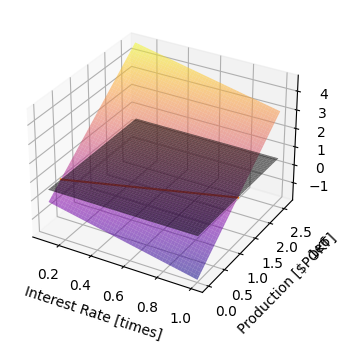

In [44]:

def LM_liquid_money(Y_production : float, 
                    r_interest_rate : float,
                    k1 = 1.,
                    k2 = 1.,
                    a = 1.,
                    b = 1.,
                    ) -> float:
    '''
    ...

    Parameters:
        Y_production : Network production in $POKT.
        r_interest_rate : Interest rate in times.
        a, b, k1, k2 : Parameters of the LM function.
    Returns:
        LM : Equilibrium point in relays.
    '''

    LM =  b*(np.power(Y_production, k2)) - (a * np.power(r_interest_rate,k1))
    
    return LM

# This is probably the most complex of all, we have no idea how the interest
# rate works with the production, we only know:
# - Higher interest rate means less production
# - Current interest rate means current production
# - The family of LM curves must respect the historical produced relays Y/p

# We assume that it is linear, why not...
k1_lm = 1
k2_lm = 1
# We divide the weight of production and interest rate between the two terms,
# Production taking twice and balanced by a unit reduction from interest rate
lm_total = (pokt_supply/PNI_relay_price_POKT)
lm_y_prop = 2
lm_r_prop =  1-lm_y_prop
# We are at lower limit production (as function of interest), this means that :
b_lm = ((lm_total*lm_y_prop)/np.power(pokt_production_per_day,k2_lm))
a_lm = -((lm_total*lm_r_prop)/np.power(pokt_rate,k1_lm))

# Current state check
assert (pokt_supply/PNI_relay_price_POKT) == LM_liquid_money(pokt_production_per_day, 
                                                             pokt_rate, 
                                                             k1=k1_lm, 
                                                             k2=k2_lm, 
                                                             a=a_lm, 
                                                             b=b_lm)
# Create plot
rl = np.linspace(0.1,1.0,100)
yl = np.linspace(pokt_production_per_day*0.01,pokt_production_per_day*5.,100)
curve = ((pokt_supply/PNI_relay_price_POKT) + (a_lm*np.power(rl,k1_lm)))/b_lm

r, y = np.meshgrid(rl,
                   yl)
lm = np.array(LM_liquid_money(np.ravel(y), 
                      np.ravel(r), 
                      k1=k1_lm, 
                      k2=k2_lm, 
                      a=a_lm, 
                      b=b_lm))
lm = lm.reshape(r.shape)
plane = np.ones_like(lm)*(pokt_supply/PNI_relay_price_POKT)



fig = plt.figure(dpi = 100)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(r, y, lm, cmap='plasma', alpha=0.55)

ax.plot_surface(r, y, plane, color='black', alpha=0.55)
ax.plot(rl, curve, np.ones_like(curve)*(pokt_supply/PNI_relay_price_POKT))

plt.ylabel('Production [$POKT]')
plt.xlabel('Interest Rate [times]')
plt.savefig(OUTPUT_IMG_PATH + '/LM.pdf', dpi=300, bbox_inches='tight')
plt.show()

### DAO

In [45]:
def DAO_spending_fn(e_exchange_rate : float, 
                      d_0 = 0.,
                      d_1 = 100.,
                     ) -> float:
    '''
    The spending of the DAO is generaly to pay for external products, hence
    it will depend on the exchange rate.

    Parameters:
        e_exchange_rate : Exchange rate in [$POKT/u$d].
        d_0 : DAO base spending in $POKT.
        d_1 : DAO base spending in u$d.
    Returns:
        D : DAO spending in $POKT
    '''

    D = d_0 + d_1*e_exchange_rate

    return D

### Investment

/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


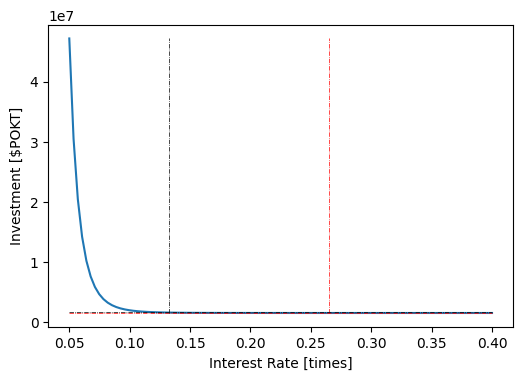

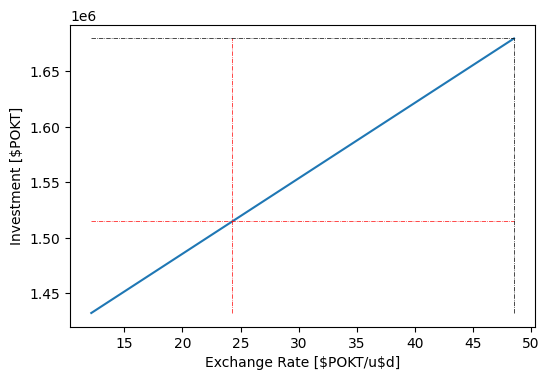

In [46]:
def I_investment(r_interest_rate : float,
                 e_exchange_rate : float, 
                 i_0=100.,
                 k = 100.,
                 i_h=lambda x: x*100.,
                 a=100000.) -> float:
    '''
    Calculates the investment as a function of the interest rate

    Parameters:
        r_interest_rate : Interest rate in times.
        e_exchange_rate : Exchange rate in [$POKT/u$d].
        i_0 : Base staked pokt at infinite interest rate [$POKT].
        i_h : Function of price, resulting in investement/holded pokt at 
              infinite interest rate [$POKT].
        a : Homographic function parameter (this name is probably wrong).
    Returns:
        I : Investment in $POKT
    '''
    
    I=a/(r_interest_rate**k)+i_0+i_h(e_exchange_rate)
    return I

# We know that given infinite interest rate, the staking is the current.
# This should be a function of the staking return.

# To fit this curve we need more data. We dont have more data...
# Its up to the user to guess how much more production we will have if the
# interest rate drops. This means, someone lends money and someone takes it to
# put it in production.
# ...
# Let's say that:
r_interest_rate_guess = [
    pokt_rate/2.0, 
    pokt_rate, 
    10
    ]
I_guess = [
    1.1 * investment_day, 
    investment_day, 
    investment_day*0.999]
# Lets fit
param_bounds=([0., -np.inf, -np.inf],[np.inf, np.inf, np.inf])
popt, pcov = curve_fit(lambda x,y,z, k : I_investment(x, 1/price_pokt_usd, k=k, i_0=z, a=y, i_h=lambda x : 0), 
                        r_interest_rate_guess, 
                        I_guess,
                        bounds=param_bounds)
a_investment_param = popt[0]
i_0_set = popt[1]
k_set = popt[2]


# We also know that holding is balancing the equation, and that holding is 
# direct to price (actually is direct to first derivative of price).
# So, if price goes down, holding goes down as more people invest or sale.
# We know that this value is currently equilibrating production:
current_imbalance = pokt_production_per_day - \
     C_consumption(pokt_production_per_day, pokt_production_per_day*DAO_earning_prop, c_0=c_0, c_1=c_1, c_2=c_2) -\
     DAO_spending_fn(1/price_pokt_usd, d_1=dao_spending*price_pokt_usd) -\
     NX_current_account(1/price_pokt_usd, 
                        pokt_production_per_day, 
                        network_profit=network_profit, 
                        network_cost=network_cost,
                        rttm = rttm_avg,
                        app_burn_rate = app_burn_rate_ini)
# k=1/4
# i_h_set = lambda x: ((current_imbalance-investment_day)/(price_pokt_usd**(k)))*1/(x**(k))
# Let's say that:
exchange_rate_guess = [
    1/price_pokt_usd, 
    2/price_pokt_usd, 
    ]
I_guess = [
    current_imbalance-investment_day, 
    (current_imbalance-investment_day)*1.2, 
    ]
i_h_set = lambda x, a, b: a*x+b
# Lets fit
param_bounds=([0., -np.inf],[np.inf, np.inf])
popt, pcov = curve_fit(i_h_set, 
                        exchange_rate_guess, 
                        I_guess,
                        bounds=param_bounds)
i_h_set = lambda x: popt[0]*x+popt[1]



# Create plot
r = np.linspace(0.05,0.4,100)
i = I_investment(r, 
                 1/price_pokt_usd, 
                 k=k_set,
                 i_0=i_0_set, 
                 i_h=i_h_set, 
                 a=a_investment_param)
plt.figure(dpi = 100)
plt.plot(r, i)
plt.ylabel('Investment [$POKT]')
plt.xlabel('Interest Rate [times]')
plt.hlines(y=current_imbalance, xmin = r.min(), xmax = r.max(), linestyles='-.', color='red', linewidth=0.5)
plt.vlines(x=pokt_rate, ymin = i.min(), ymax = i.max(), linestyles='-.', color='red', linewidth=0.5)
plt.vlines(x=r_interest_rate_guess[0], ymin = i.min(), ymax = i.max(), linestyles='-.', color='black', linewidth=0.5)
plt.hlines(y=I_guess[0]-investment_day+current_imbalance, xmin = r.min(), xmax = r.max(), linestyles='-.', color='black', linewidth=0.5)
plt.savefig(OUTPUT_IMG_PATH + '/I_r.pdf', dpi=300, bbox_inches='tight')
plt.show()


e = np.linspace(0.5/price_pokt_usd,2/price_pokt_usd,100)
i = I_investment(pokt_rate, 
                 e, 
                 k=k_set,
                 i_0=i_0_set, 
                 i_h=i_h_set, 
                 a=a_investment_param)
plt.figure(dpi = 100)
plt.plot(e, i)
plt.ylabel('Investment [\$POKT]')
plt.xlabel('Exchange Rate [\$POKT/u\$d]')
plt.hlines(y=(current_imbalance), xmin = e.min(), xmax = e.max(), linestyles='-.', color='red', linewidth=0.5)
plt.vlines(x=1/price_pokt_usd, ymin = i.min(), ymax = i.max(), linestyles='-.', color='red', linewidth=0.5)
plt.hlines(y=investment_day+((current_imbalance-investment_day)*1.2), xmin = e.min(), xmax = e.max(), linestyles='-.', color='black', linewidth=0.5)
plt.vlines(x=2/price_pokt_usd, ymin = i.min(), ymax = i.max(), linestyles='-.', color='black', linewidth=0.5)
plt.savefig(OUTPUT_IMG_PATH + '/I_epsilon.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Macro Economic System

In [47]:
# Equations

# ------------------ 1 ------------------
# 0 = Y_eq 
#     - C_consumption(Y_eq, T_dao_earning) 
#     - I_investment(r_eq)
#     - G_dao_spending
#     - NX_current_account(e_eq, Y_eq)

# ------------------ 2 ------------------
# 0 = LM_liquid_money(Y_eq, r_eq)
#     - (M_pokt_supply / p_relay_price)

# ------------------ 3 ------------------
# 0 = NX_current_account(e_eq, Y_eq)
#     + F_capital_account(r_eq, r_interest_rate_external)

# Unknowns:
# Y_eq
# r_eq
# e_eq

def eq_system(vars, 
              network_profit_test = network_profit, 
              network_cost_test = network_cost,
              rttm_test = rttm_avg,
              app_burn_rate_test = app_burn_rate_ini,
              RESTRICTED_MODE = False,
              r_eq_rest=pokt_rate, 
              Y_eq_rest=pokt_production_per_day, 
              ):
       
       if RESTRICTED_MODE:
              Y_eq = np.abs(Y_eq_rest)
              r_eq = np.abs(r_eq_rest)
              e_eq = np.abs(vars[0])
       else:
              Y_eq, r_eq, e_eq = vars
              Y_eq = np.abs(Y_eq)
              r_eq = np.abs(r_eq)
              e_eq = np.abs(e_eq)
       
       eq_1 = Y_eq - \
              C_consumption(Y_eq, Y_eq*(DAO_earning_prop+VAL_proportion), c_0=c_0, c_1=c_1, c_2=c_2) - \
              I_investment(r_eq, 
                           e_eq,
                           i_0=i_0_set, 
                           i_h=i_h_set,
                           k=k_set,
                           a=a_investment_param) - \
              DAO_spending_fn(e_eq, d_1=dao_spending*price_pokt_usd) - \
              NX_current_account(e_eq, 
                            Y_eq, 
                            network_profit=network_profit_test, 
                            network_cost=network_cost_test,
                            rttm=rttm_test,
                            app_burn_rate=app_burn_rate_test)
       
       

       eq_2 = LM_liquid_money(Y_eq, 
                            r_eq, 
                            k1=k1_lm, 
                            k2=k2_lm, 
                            a=a_lm, 
                            b=b_lm) - (pokt_supply/(PNI_relay_price/e_eq))

       eq_3 = NX_current_account(e_eq, 
                            Y_eq, 
                            network_profit=network_profit_test, 
                            network_cost=network_cost_test,
                            rttm=rttm_test,
                            app_burn_rate=app_burn_rate_test) + \
              F_capital_account(r_eq, 
                            ETH_POKT_rate, 
                            e_eq,
                            h=h_capital_acc,
                            h_0=h_0_capital_acc,
                            h_k=h_k_capital_acc,
                            b=b_capital_acc,
                            c=c_capital_acc)
       if RESTRICTED_MODE:
              return [eq_3]
       else:
              return [eq_1, eq_2, eq_3]

In [48]:
eq_system((pokt_production_per_day, pokt_rate, (1/price_pokt_usd)))

[-5.471520125865936e-09, 1.0, -5772.590033272514]

In [49]:
eq_system([1/price_pokt_usd], RESTRICTED_MODE=True)

[-5772.590033272514]

In [50]:
def get_equilibrium(
        use_restricted_mode,
        this_network_profit,
        this_network_cost,
        this_rttm,
        this_app_burn_rate,
        this_pokt_interest_rate,
        this_pokt_production_per_day,
        verbose = False,
        initial_guess = None,
):
    if initial_guess == None:
        if use_restricted_mode:
            initial_guess = [1/price_pokt_usd]
        else:
            initial_guess = [pokt_production_per_day, pokt_rate, 1/price_pokt_usd]

    sol = fsolve(lambda x : eq_system(x,
                                    network_profit_test = this_network_profit, 
                                    network_cost_test = this_network_cost,
                                    rttm_test = this_rttm,
                                    app_burn_rate_test = this_app_burn_rate,
                                    RESTRICTED_MODE = use_restricted_mode,
                                    r_eq_rest=this_pokt_interest_rate, 
                                    Y_eq_rest=this_pokt_production_per_day, 
                                    ), initial_guess)
    if use_restricted_mode:
        Y_eq = np.abs(this_pokt_production_per_day)
        r_eq = np.abs(this_pokt_interest_rate)
        e_eq = np.abs(sol[0])
    else:
        Y_eq = np.abs(sol[0])
        r_eq = np.abs(sol[1])
        e_eq = np.abs(sol[2])

    if verbose:
        print('Macro economic equilibrium:')
        print('\tProduction : %g POKT (%g relays)'%(Y_eq, (Y_eq/rttm_avg)))
        print('\tInterest Rate : %g %%'%(r_eq*100.))
        print('\tPOKT price : %0.4f u$d/$POKT'%(1.0/e_eq))
    
    return Y_eq, r_eq, e_eq

In [51]:
use_restricted_mode = True
this_network_profit = None # Use app burn
this_pokt_interest_rate = pokt_rate
if use_restricted_mode:
    initial_guess = [50]
else:
    initial_guess = [pokt_production_per_day, pokt_rate, 50]
# Create parameter search space
rttm_ini = 0.00005
rttm_end = 0.0004
rttm_list = np.linspace(rttm_ini, rttm_end, 10)
app_burn_rate_usd_ini = 0.#00000085
app_burn_rate_usd_end = 0.00000500
app_burn_list = np.linspace(app_burn_rate_usd_ini, app_burn_rate_usd_end, 10)
network_cost_day_ini = 10000
network_cost_day_end = 40000
network_cost_list = np.linspace(network_cost_day_ini, network_cost_day_end, 10)
number_relays_ini = 1.2e9
number_relays_end = 12e9
number_relays_list = np.linspace(number_relays_ini, number_relays_end, 10)
params_space = {
    "rttm": rttm_list,
    "app_burn_rate_usd":app_burn_list,
    "network_cost": network_cost_list,
    "relays": number_relays_list,
}
parameter_space = ParameterGrid(params_space)

# All data
rows = list()

for grid_point in tqdm(ParameterGrid(params_space)):
        

    this_network_cost = lambda x: grid_point["network_cost"]
    this_rttm = grid_point["rttm"]
    this_app_burn_rate = grid_point["app_burn_rate_usd"]/price_pokt_usd
    this_pokt_production_per_day = this_rttm*grid_point["relays"]

    # Get equlibrium
    Y_eq, r_eq, e_eq = get_equilibrium(
                    use_restricted_mode,
                    this_network_profit,
                    this_network_cost,
                    this_rttm,
                    this_app_burn_rate,
                    this_pokt_interest_rate,
                    this_pokt_production_per_day,
                    verbose = False,
                    initial_guess = initial_guess,
                    )
    
    # Calculate network profit
    profit = (grid_point["relays"]*this_app_burn_rate)-this_pokt_production_per_day
    
    rows.append([
        grid_point["network_cost"],
        this_rttm,
        grid_point["app_burn_rate_usd"],
        this_app_burn_rate,
        this_pokt_production_per_day,
        grid_point["relays"],
        profit,
        1/e_eq,
        Y_eq,
        r_eq,
        e_eq
    ])
    
    
    

  9%|███████████▉                                                                                                                                 | 851/10000 [00:00<00:04, 2033.18it/s]/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
 11%|██████████████▊                                                                                                                             | 1055/10000 [00:00<00:05, 1749.05it/s]/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1159.

In [52]:
sim_df = pd.DataFrame(rows, columns=[
    "network_cost",
        'rttm',
        'app_burn_rate_usd',
        'app_burn_rate',
        'pokt_production_per_day',
        'relays',
        'profit',
        'exchange_rate',
        'Y_eq',
        'r_eq',
        'e_eq'
])

In [53]:
sim_df['profit'].max()

857017.9698882953

In [54]:
sim_df.sort_values(['profit'], ascending=False)

,network_cost,rttm,app_burn_rate_usd,app_burn_rate,pokt_production_per_day,relays,profit,exchange_rate,Y_eq,r_eq,e_eq
9390,20000.000000,0.00005,0.000005,0.000121,600000.0,1.200000e+10,8.570180e+05,0.129301,600000.0,0.264806,7.733911
9890,36666.666667,0.00005,0.000005,0.000121,600000.0,1.200000e+10,8.570180e+05,0.089236,600000.0,0.264806,11.206183
9790,33333.333333,0.00005,0.000005,0.000121,600000.0,1.200000e+10,8.570180e+05,0.094567,600000.0,0.264806,10.574492
9990,40000.000000,0.00005,0.000005,0.000121,600000.0,1.200000e+10,8.570180e+05,0.084218,600000.0,0.264806,11.873956
9290,16666.666667,0.00005,0.000005,0.000121,600000.0,1.200000e+10,8.570180e+05,0.141489,600000.0,0.264806,7.067687
...,...,...,...,...,...,...,...,...,...,...,...
599,26666.666667,0.00040,0.000000,0.000000,4800000.0,1.200000e+10,-4.800000e+06,0.054663,4800000.0,0.264806,18.293785
499,23333.333333,0.00040,0.000000,0.000000,4800000.0,1.200000e+10,-4.800000e+06,0.059218,4800000.0,0.264806,16.886876
299,16666.666667,0.00040,0.000000,0.000000,4800000.0,1.200000e+10,-4.800000e+06,0.071058,4800000.0,0.264806,14.073058
199,13333.333333,0.00040,0.000000,0.000000,4800000.0,1.200000e+10,-4.800000e+06,0.078951,4800000.0,0.264806,12.666149


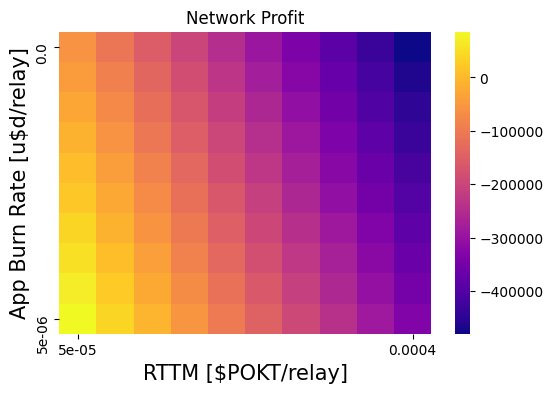

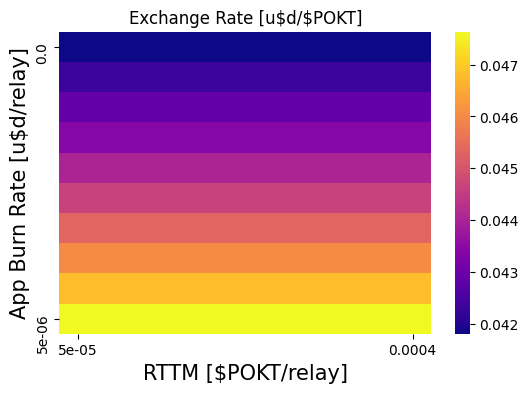

In [55]:
network_cost_level = network_cost_list[-1]
number_relays_level = number_relays_list[0]

aux_df = sim_df.loc[(sim_df['network_cost'] == network_cost_level) *\
           (sim_df['relays'] == number_relays_level)
           ]
pivot_df = aux_df.pivot(index='app_burn_rate_usd', columns='rttm', values='profit')

plt.figure(dpi=100)
sns.heatmap(pivot_df, cmap="plasma", xticklabels=9, yticklabels=9)
plt.title('Network Profit')
plt.xlabel('RTTM [\$POKT/relay]', fontsize = 15) 
plt.ylabel('App Burn Rate [u\$d/relay]', fontsize = 15)
plt.savefig(OUTPUT_IMG_PATH + '/RTTM_ABR_network_profit.pdf', dpi=300, bbox_inches='tight')
plt.show()

pivot_df = aux_df.pivot(index='app_burn_rate_usd', columns='rttm', values='exchange_rate')

plt.figure(dpi=100)
sns.heatmap(pivot_df, cmap="plasma", xticklabels=9, yticklabels=9)
plt.title('Exchange Rate [u\$d/\$POKT]')
plt.xlabel('RTTM [\$POKT/relay]', fontsize = 15) 
plt.ylabel('App Burn Rate [u$d/relay]', fontsize = 15)
plt.savefig(OUTPUT_IMG_PATH + '/RTTM_ABR_epsilon_rate.pdf', dpi=300, bbox_inches='tight')
plt.show()


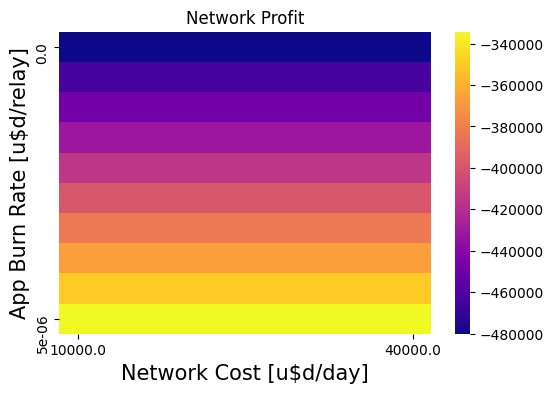

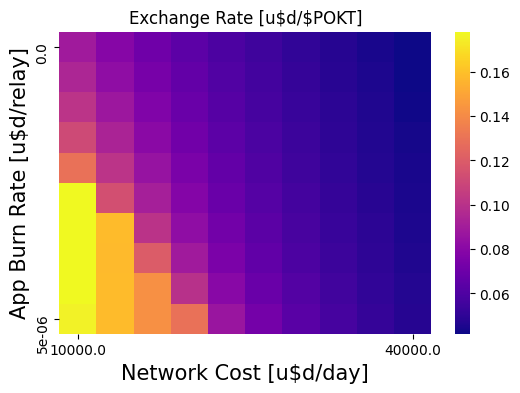

In [56]:
rttm_level = rttm_list[-1]
number_relays_level = number_relays_list[0]

aux_df = sim_df.loc[(sim_df['rttm'] == rttm_level) *\
           (sim_df['relays'] == number_relays_level)
           ]
pivot_df = aux_df.pivot(index='app_burn_rate_usd', columns='network_cost', values='profit')

plt.figure(dpi=100)
sns.heatmap(pivot_df, cmap="plasma", xticklabels=9, yticklabels=9)
plt.title('Network Profit')
plt.xlabel('Network Cost [u\$d/day]', fontsize = 15) 
plt.ylabel('App Burn Rate [u\$d/relay]', fontsize = 15)
plt.savefig(OUTPUT_IMG_PATH + '/NC_ABR_network_profit.pdf', dpi=300, bbox_inches='tight')
plt.show()

pivot_df = aux_df.pivot(index='app_burn_rate_usd', columns='network_cost', values='exchange_rate')

plt.figure(dpi=100)
sns.heatmap(pivot_df, cmap="plasma", xticklabels=9, yticklabels=9)
plt.title('Exchange Rate [u\$d/\$POKT]')
plt.xlabel('Network Cost [u\$d/day]', fontsize = 15) 
plt.ylabel('App Burn Rate [u$d/relay]', fontsize = 15)
plt.savefig(OUTPUT_IMG_PATH + '/NC_ABR_network_profit.pdf', dpi=300, bbox_inches='tight')
plt.show()


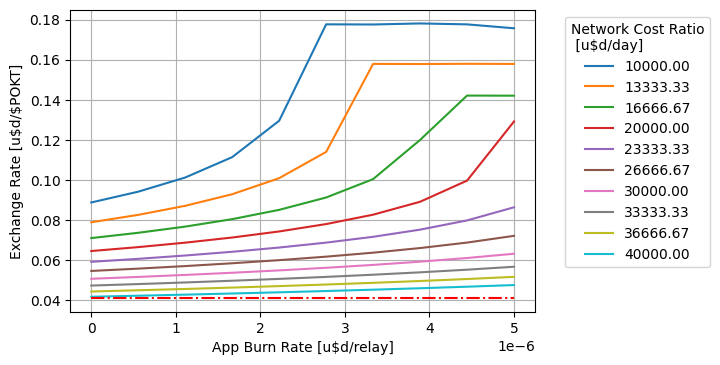

In [57]:
plt.figure(dpi=100)
ax = plt.gca()
legends=list()
for net_cost_level in network_cost_list:
    aux_df = sim_df.loc[(sim_df['rttm'] == rttm_list[-1]) *\
           (sim_df['relays'] == number_relays_list[0])
           ]
    aux_df = aux_df.loc[(sim_df['network_cost'] == net_cost_level)]
    aux_df.plot(x='app_burn_rate_usd', y='exchange_rate', ax=ax, )
    legends.append('%0.2f'%net_cost_level)
    
plt.xlabel('App Burn Rate [u\$d/relay]')
plt.ylabel('Exchange Rate [u\$d/\$POKT]')
plt.legend(legends, bbox_to_anchor=(1.05, 1), loc='upper left', title='Network Cost Ratio\n [u\$d/day]')
plt.hlines(y=price_pokt_usd, xmin = app_burn_list[0], xmax = app_burn_list[-1], linestyles='-.', color='red', linewidth=1.5)
plt.grid()
plt.savefig(OUTPUT_IMG_PATH + '/ABR_epsilon_NC_ratio.pdf', dpi=300, bbox_inches='tight')
plt.show()


### Functions of Network Cost and App Burn

In [58]:
use_restricted_mode = False
this_network_profit = None # Use app burn
this_pokt_interest_rate = pokt_rate
if use_restricted_mode:
    initial_guess = [50]
else:
    initial_guess = [pokt_production_per_day, 0.5, 25]

this_rttm = rttm_avg
this_relays = 1.2e9

# Create parameter search space
app_burn_rate_usd_ini = 0.#00000085
app_burn_rate_usd_end = 0.00000500
app_burn_list = np.linspace(app_burn_rate_usd_ini, app_burn_rate_usd_end, 10)
network_cost_day_ini = 10000
network_cost_day_end = 40000
network_cost_list = np.linspace(network_cost_day_ini, network_cost_day_end, 10)
params_space = {
    "app_burn_rate_usd":app_burn_list,
    "network_cost": network_cost_list,
}
parameter_space = ParameterGrid(params_space)

# All data
rows = list()

for grid_point in tqdm(ParameterGrid(params_space)):
        

    this_network_cost = lambda x: grid_point["network_cost"]
    
    this_app_burn_rate = grid_point["app_burn_rate_usd"]/price_pokt_usd
    this_pokt_production_per_day = this_rttm*this_relays

    # Get equlibrium
    Y_eq, r_eq, e_eq = get_equilibrium(
                    use_restricted_mode,
                    this_network_profit,
                    this_network_cost,
                    this_rttm,
                    this_app_burn_rate,
                    this_pokt_interest_rate,
                    this_pokt_production_per_day,
                    verbose = False,
                    initial_guess = initial_guess,
                    )
    
    # Calculate network profit
    profit = (this_relays*this_app_burn_rate)-this_pokt_production_per_day
    
    rows.append([
        grid_point["network_cost"],
        this_rttm,
        grid_point["app_burn_rate_usd"],
        this_app_burn_rate,
        this_pokt_production_per_day,
        this_relays,
        profit,
        1/e_eq,
        Y_eq/this_rttm,
        Y_eq,
        r_eq,
        e_eq
    ])
    
    
    

  0%|                                                                                                                                                           | 0/100 [00:00<?, ?it/s]/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
 32%|██████████████████████████████████████████████▍                                                                                                  | 32/100 [00:00<00:00, 317.57it/s]/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 285.

In [59]:
sim_df = pd.DataFrame(rows, columns=[
    "network_cost",
        'rttm',
        'app_burn_rate_usd',
        'app_burn_rate',
        'pokt_production_per_day',
        'relays',
        'profit',
        'exchange_rate',
        'relays_eq',
        'Y_eq',
        'r_eq',
        'e_eq'
])

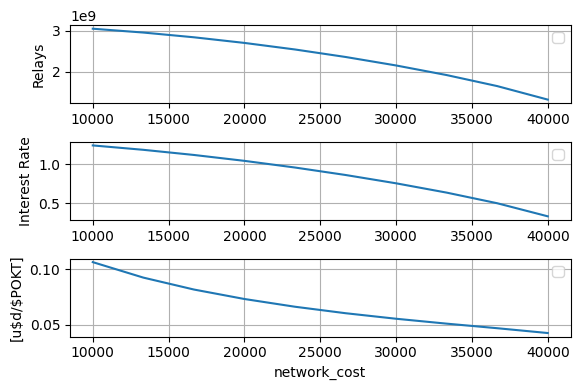

In [60]:
app_burn_level = app_burn_list[0]

aux_df = sim_df.loc[(sim_df['app_burn_rate_usd'] == app_burn_level)]

plt.figure(dpi=100)
ax = plt.subplot(3,1,1)
aux_df.plot(x='network_cost', y='relays_eq', ax=ax)
ax.legend([])
ax.grid()
ax.set_xlabel('')
ax.set_ylabel('Relays')
ax = plt.subplot(3,1,2)
aux_df.plot(x='network_cost', y='r_eq', ax=ax)
ax.legend([])
ax.grid()
ax.set_xlabel('')
ax.set_ylabel('Interest Rate')
ax = plt.subplot(3,1,3)
aux_df.plot(x='network_cost', y='exchange_rate', ax=ax)
ax.legend([])
ax.grid()
ax.set_ylabel('[u\$d/\$POKT]')
plt.tight_layout()
plt.savefig(OUTPUT_IMG_PATH + '/FME_current_ABR.pdf', dpi=300, bbox_inches='tight')
plt.show()

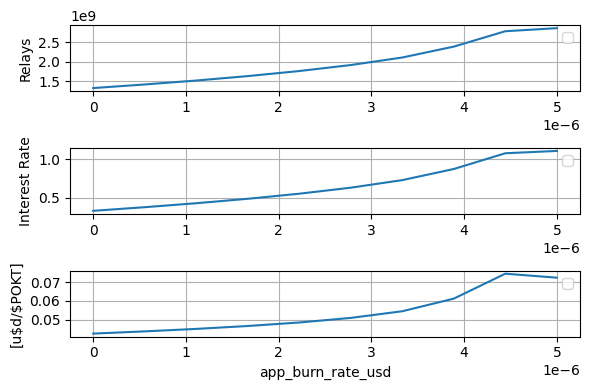

In [61]:
net_cost_level = network_cost_list[-1]

aux_df = sim_df.loc[(sim_df['network_cost'] == net_cost_level)]

plt.figure(dpi=100)
ax = plt.subplot(3,1,1)
aux_df.plot(x='app_burn_rate_usd', y='relays_eq', ax=ax)
ax.legend([])
ax.grid()
ax.set_xlabel('')
ax.set_ylabel('Relays')
ax = plt.subplot(3,1,2)
aux_df.plot(x='app_burn_rate_usd', y='r_eq', ax=ax)
ax.legend([])
ax.grid()
ax.set_xlabel('')
ax.set_ylabel('Interest Rate')
ax = plt.subplot(3,1,3)
aux_df.plot(x='app_burn_rate_usd', y='exchange_rate', ax=ax)
ax.legend([])
ax.grid()
ax.set_ylabel('[u\$d/\$POKT]')
plt.tight_layout()
plt.savefig(OUTPUT_IMG_PATH + '/FME_current_NC.pdf', dpi=300, bbox_inches='tight')
plt.show()

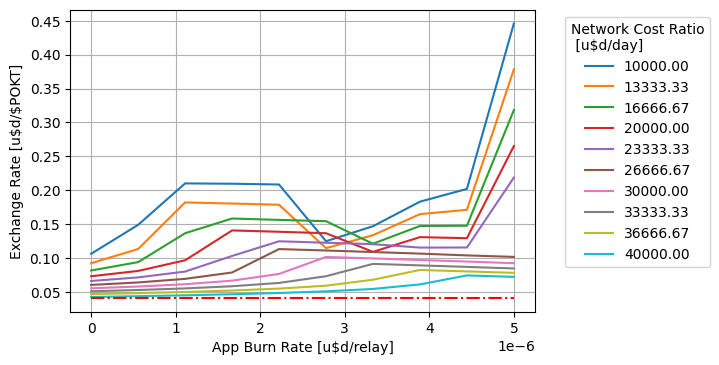

In [62]:
plt.figure(dpi=100)
ax = plt.gca()
legends=list()
for net_cost_level in network_cost_list:
    aux_df = sim_df.loc[(sim_df['network_cost'] == net_cost_level)]
    aux_df.plot(x='app_burn_rate_usd', y='exchange_rate', ax=ax, )
    legends.append('%0.2f'%net_cost_level)
    
plt.xlabel('App Burn Rate [u\$d/relay]')
plt.ylabel('Exchange Rate [u\$d/\$POKT]')
plt.legend(legends, bbox_to_anchor=(1.05, 1), loc='upper left', title='Network Cost Ratio\n [u\$d/day]')
plt.hlines(y=price_pokt_usd, xmin = app_burn_list[0], xmax = app_burn_list[-1], linestyles='-.', color='red', linewidth=1.5)
plt.grid()
plt.savefig(OUTPUT_IMG_PATH + '/FME_NC_ratios.pdf', dpi=300, bbox_inches='tight')
plt.show()
